# PINN learning of Kuramoto-Sivashinsky equation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


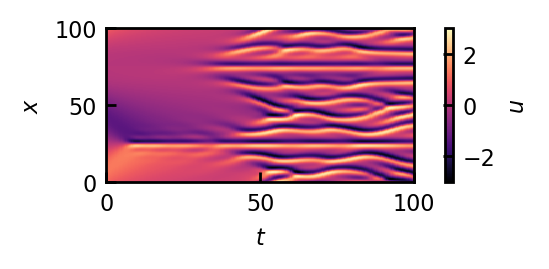

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

plt.style.use('../../figure_style.mplstyle')

# Load data
data = loadmat('../data/kuramoto_sivashinsky.mat')
U_star = data['uu']
t_star = data['tt'].T
x_star = data['x']

N = x_star.shape[0]
T = t_star.shape[0]

# Reshape data
XX = np.tile(x_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

# Plot data
def plot_field(ax, u, vmin=-3, vmax=3, label='$u$'):
    im = ax.pcolormesh(TT, XX, u, cmap='magma', vmin=vmin, vmax=vmax)
    ax.set(xlabel='$t$', xlim=[0, 100], xticks=[0, 50, 100],
           ylabel='$x$', ylim=[0, 100], yticks=[0, 50, 100],
           aspect=0.5)
    plt.colorbar(im, ax=ax, label=label)

fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_field(ax, U_star)

# Solve BVP with PINN

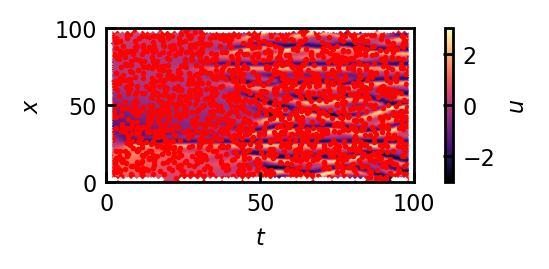

In [15]:
# Select points for bulk physics-informed loss
N_f = 2000
idx = np.random.choice(N*T, N_f, replace=False)
x_f, t_f, u_f = x[idx,:], t[idx,:], u[idx,:]

# Select boundary points for reconstruction loss
N_u = 500
idxs = np.argwhere(np.logical_or(
    np.logical_or(x == x.min(), x == x.max()),
    np.logical_or(t == t.min(), t == t.max())
))[:, 0]
idx = np.random.choice(idxs, N_u, replace=False)
x_b, t_b, u_b = x[idx,:], t[idx,:], u[idx,:]

# Plot both sets of points
fig, ax = plt.subplots(1,1, figsize=(4,1))
plot_field(ax, U_star)
ax.scatter(t_f, x_f, c='red', s=1)
ax.scatter(t_b, x_b, c='white', marker='x', s=10)

In [21]:
import torch
from kuramoto_sivashinsky_pinn import KuramotoSivashinskyBVPPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = KuramotoSivashinskyBVPPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
        x_b=x_b,
        t_b=t_b,
        u_b=u_b,
    ),
    log_dir="./tb_logs/KuramotoSivashinsky"
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 1.39400e-01, MSE: 1.30990e-01, Phys: 8.40975e-03
Iteration 2000, Loss: 1.15636e-01, MSE: 1.12847e-01, Phys: 2.78901e-03
Iteration 3000, Loss: 4.02974e-02, MSE: 3.19646e-02, Phys: 8.33286e-03
Iteration 4000, Loss: 1.23637e-02, MSE: 8.67780e-03, Phys: 3.68592e-03
Iteration 5000, Loss: 6.94045e-03, MSE: 3.77659e-03, Phys: 3.16386e-03
Iteration 6000, Loss: 4.58778e-03, MSE: 2.10059e-03, Phys: 2.48718e-03
Iteration 7000, Loss: 3.53163e-03, MSE: 2.01171e-03, Phys: 1.51992e-03
Iteration 8000, Loss: 2.70256e-03, MSE: 1.38377e-03, Phys: 1.31879e-03
Iteration 9000, Loss: 1.83914e-03, MSE: 5.85386e-04, Phys: 1.25375e-03
Iteration 10000, Loss: 1.30867e-03, MSE: 2.62820e-04, Phys: 1.04585e-03
Iteration 11000, Loss: 1.10645e-03, MSE: 2.35040e-04, Phys: 8.71408e-04
Iteration 12000, Loss: 9.65015e-04, MSE: 1.85301e-04, Phys: 7.79714e-04
Iteration 13000, Loss: 8.65016e-04, MSE: 1.53394e-04, Phys: 7.11622e-04
Iteration 14000, Loss: 8.01649e-04, MS

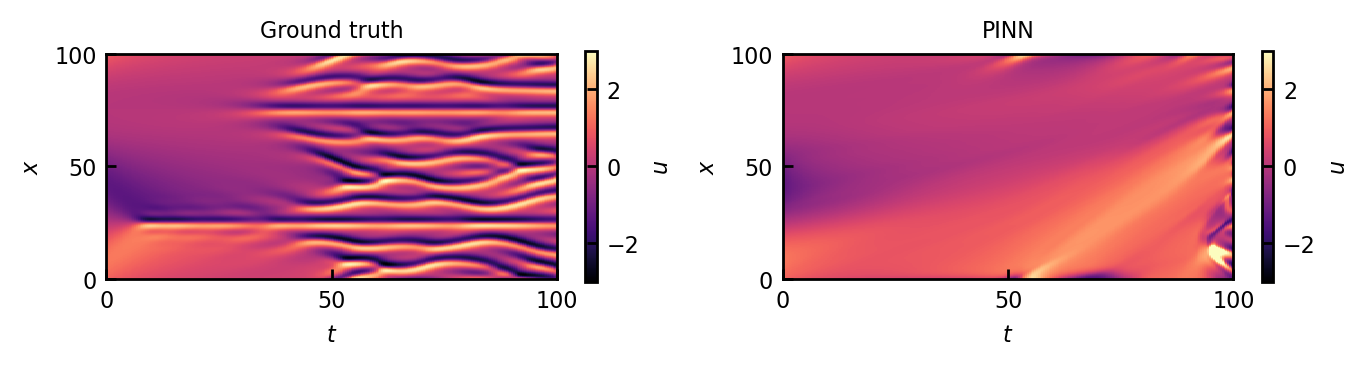

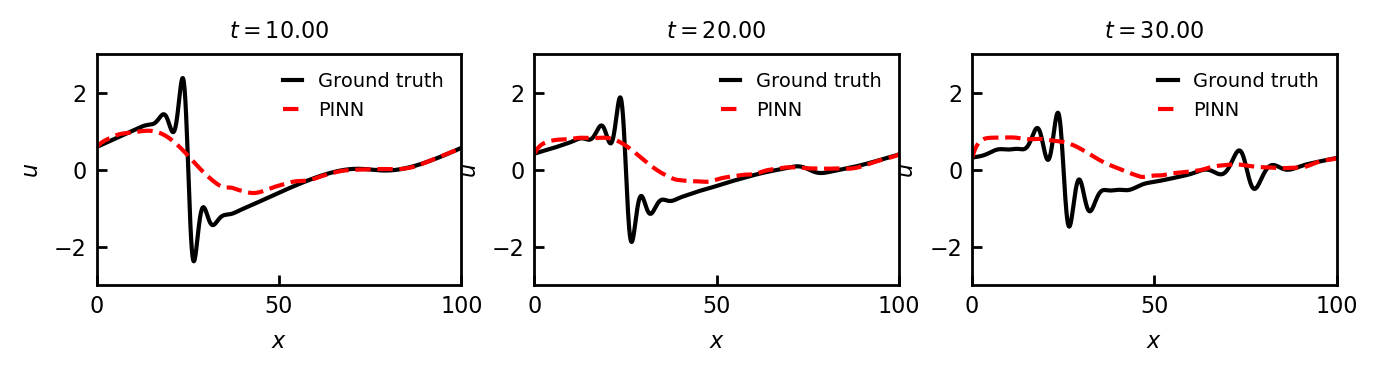

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star)
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred)
ax[1].set_title('PINN')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[0, 100], xticks=[0, 50, 100], 
          ylabel='$u$', ylim=[-3, 3], yticks=[-2, 0, 2])
    a.legend()

# Learn parameters with PINN

$$ u_t + u u_x + u_{xx} + u_{xxxx} = 0 $$

In [ ]:
import torch
from kuramoto_sivashinsky_pinn import KuramotoSivashinskyParameterPINN

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Starting to train on device {device}')

model = KuramotoSivashinskyParameterPINN(
    data=dict(
        x_f=x_f,
        t_f=t_f,
        u_f=u_f,
    ),
    log_dir="./tb_logs/KuramotoSivashinsky"
).to(device)
model.train(1)

Starting to train on device cuda:0
Iteration 1000, Loss: 3.97201e-01, MSE: 3.76223e-01, Phys: 2.09788e-02
Iteration 2000, Loss: 2.29456e-01, MSE: 2.14378e-01, Phys: 1.50781e-02
Iteration 3000, Loss: 1.70663e-01, MSE: 1.54370e-01, Phys: 1.62931e-02
Iteration 4000, Loss: 1.11844e-01, MSE: 9.41975e-02, Phys: 1.76463e-02
Iteration 5000, Loss: 6.68313e-02, MSE: 5.14219e-02, Phys: 1.54094e-02
Iteration 6000, Loss: 5.26695e-02, MSE: 3.97877e-02, Phys: 1.28819e-02
Iteration 7000, Loss: 4.33484e-02, MSE: 3.12914e-02, Phys: 1.20570e-02
Iteration 8000, Loss: 3.79118e-02, MSE: 2.73143e-02, Phys: 1.05975e-02
Iteration 9000, Loss: 3.19019e-02, MSE: 2.22332e-02, Phys: 9.66869e-03
Iteration 10000, Loss: 2.59930e-02, MSE: 1.78257e-02, Phys: 8.16731e-03
Iteration 11000, Loss: 2.19902e-02, MSE: 1.47014e-02, Phys: 7.28884e-03
Iteration 12000, Loss: 1.89317e-02, MSE: 1.27106e-02, Phys: 6.22112e-03
Iteration 13000, Loss: 1.66234e-02, MSE: 1.14750e-02, Phys: 5.14840e-03
Iteration 14000, Loss: 1.47619e-02, MS

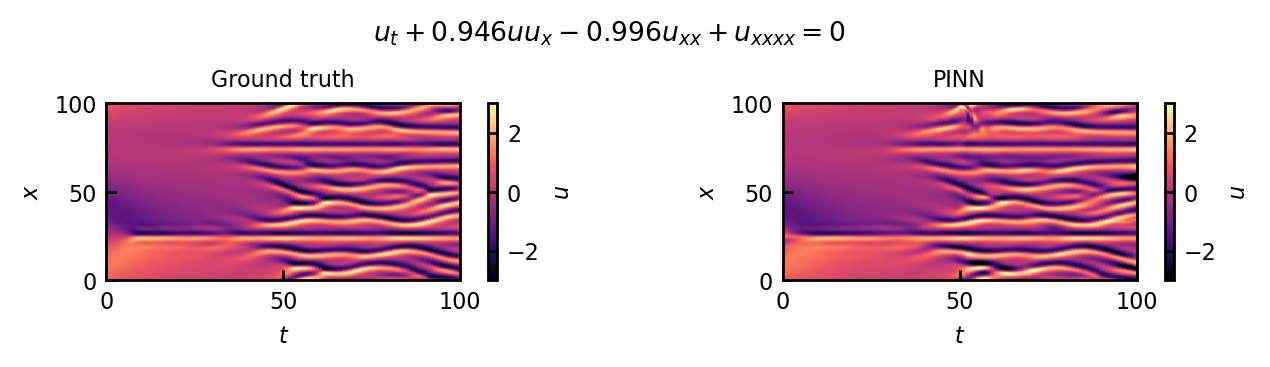

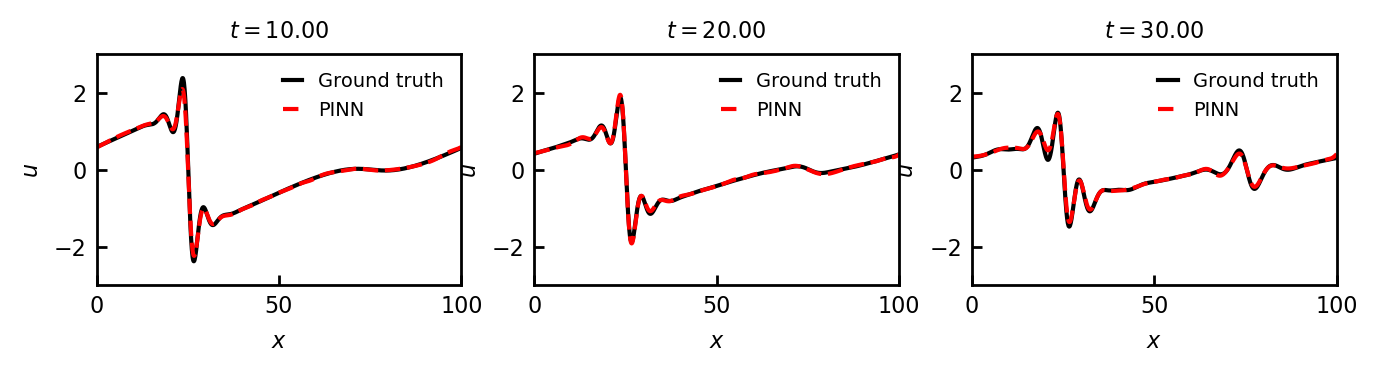

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 1.5))

plot_field(ax[0], U_star)
ax[0].set_title('Ground truth')

xt = torch.FloatTensor(np.stack([x, t], axis=-1)).to(device)
U_pred = model(xt).detach().cpu().numpy()
U_pred = U_pred.reshape(U_star.shape)
plot_field(ax[1], U_pred)
ax[1].set_title('PINN')

fig.subplots_adjust(top=0.7)
lambda_1, lambda_2 = model.get_params()
fig.suptitle(f'$u_t + {lambda_1.detach().item():.3g} u u_x + {lambda_2.detach().item():.3g} u_{{xx}} + u_{{xxxx}} = 0$')

fig, ax = plt.subplots(1, 3, figsize=(8, 1.5))

ax[0].plot(x_star, U_star[:,25], color='black', label='Ground truth')
ax[1].plot(x_star, U_star[:,50], color='black', label='Ground truth')
ax[2].plot(x_star, U_star[:,75], color='black', label='Ground truth')

ax[0].plot(x_star, U_pred[:,25], color='red', linestyle='--', label='PINN')
ax[1].plot(x_star, U_pred[:,50], color='red', linestyle='--', label='PINN')
ax[2].plot(x_star, U_pred[:,75], color='red', linestyle='--', label='PINN')

ax[0].set_title(f'$t = {t_star[25,0]:.2f}$')
ax[1].set_title(f'$t = {t_star[50,0]:.2f}$')
ax[2].set_title(f'$t = {t_star[75,0]:.2f}$')

for a in ax:
    a.set(xlabel='$x$', xlim=[0, 100], xticks=[0, 50, 100], 
          ylabel='$u$', ylim=[-3, 3], yticks=[-2, 0, 2])
    a.legend()